In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Transformation Et Manipulation Des Données<br>
    </h1>
    MovieLens - Système de recommendations de films par regroupement<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <br>
    420-A56<br>
    <br>
</center>

# Introduction
<br>
<font class="answer">
    
J'ai choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle se compose de 100836 notes représentant 9742 films. Elle contient également les métadonnées sur 19 genres et des liens sur [TMDB](https://www.themoviedb.org) qui permettront d'augmemter son contenu.
    
Plus spécifiquement, (Voir https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html et décrire en détails le format)
    
    
    
L'objectif de ce projet est de contruire un système de recommentation de films en utilisant les techniques de regroupement vu dans le cours. Les détails du sytème seront abordés plus loins dans ce notebooks

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import time

from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm.notebook import tqdm

#
# imports faisant partie de mes propres module
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.dataset.MovieLens as mvl
import helpers.WebScraping as scrap
import helpers.jupyter as jup

# Prétraitement

<font class="answer">

Description ici?

In [3]:
#
# parametres configurant nos traitemens
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset
#
mvl_dataset = mvl.load(configs.dataset)

In [4]:
df = pd.read_csv("./dataset/ratings.csv", delimiter=',')

In [5]:
print(df)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


In [6]:
df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [7]:
df = df.drop("timestamp", axis=1)

In [8]:
table = pd.crosstab(df.userId, df.movieId).astype(bool)



In [9]:
table1 = pd.crosstab(df.userId, df.movieId).sum(axis=1)


In [10]:
display(table1)

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Length: 610, dtype: int64

In [11]:
table.shape

(610, 9724)

In [12]:
print("Nombre de user", table.shape[0])
print("Nombre de film", table.shape[1])


Nombre de user 610
Nombre de film 9724


In [13]:
table.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
from numpy import linalg as LA


The Minimum Support Count would be count of transactions, so it would be 60% of the total number of transactions. If the number of transactions is 5, your minimum support count would be 5*60/100 = 3.

In [15]:
choix_min_support = [0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.25, 0.28, 0.3, 0.4]
print("Nombres correspondants:", [
      int(choix_min_support[i]*table.shape[0]) for i in range(len(choix_min_support))])


Nombres correspondants: [73, 85, 97, 109, 122, 134, 152, 170, 183, 244]


In [16]:
num_freq_itemset, freq_itemsets = [], []
for minsup in choix_min_support:
    freq_items = apriori(table, min_support=minsup, max_len=9, use_colnames=True)
    freq_itemsets.append(freq_items)
    num_freq_itemset.append(freq_items.shape[0])
result_df = pd.DataFrame({'minsup':choix_min_support, 'num_items': num_freq_itemset, 'itemsets':freq_itemsets})
result_df[['minsup','num_items']]

,minsup,num_items
0,0.12,18259
1,0.14,5079
2,0.16,1886
3,0.18,807
4,0.20,413
5,0.22,213
6,0.25,103
7,0.28,55
8,0.30,39
9,0.40,6


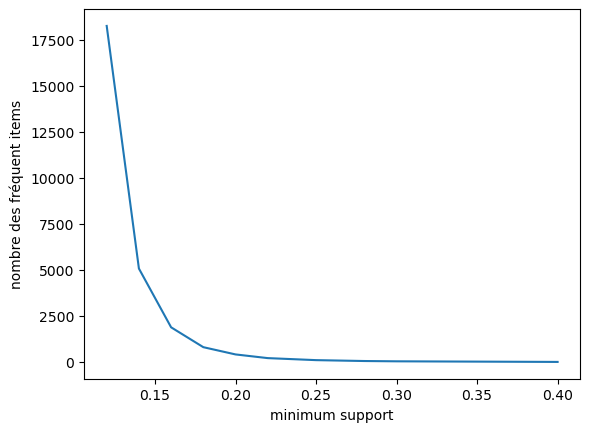

In [17]:
plt.plot(result_df.minsup, result_df.num_items)
plt.xlabel("minimum support")
plt.ylabel("nombre des fréquent items")
plt.show()


In [18]:
# initialise un petit seuil de confidence 10% afin de trouver maximum de règles
num_rules, rules, min_conf = [], [], 0.1
for f_items in freq_itemsets:
    ar = association_rules(f_items, metric='confidence', min_threshold=min_conf)
    rules.append(ar.sort_values(by='lift', ascending=False))
    num_rules.append(ar.shape[0])
result_df['num_rules'] = num_rules     
result_df['rules'] = rules
result_df[['minsup','num_items', 'num_rules']]

,minsup,num_items,num_rules
0,0.12,18259,243702
1,0.14,5079,41278
2,0.16,1886,10214
3,0.18,807,3062
4,0.20,413,1150
5,0.22,213,450
6,0.25,103,152
7,0.28,55,44
8,0.30,39,22
9,0.40,6,0


In [19]:
#result_df.loc[4,'itemsets']


In [20]:
result_df.loc[2,['minsup','num_items', 'num_rules']]

minsup        0.16
num_items     1886
num_rules    10214
Name: 2, dtype: object

In [21]:
col_display = ["antecedents", "consequents", "confidence", "lift"]
print("Toutes les regles")
for idx in range(1, 3):
    print("="*60)
    print("-"*20, f"min_support = {result_df.minsup[idx]}", "-"*20)
    print(result_df.rules[idx][col_display])


Toutes les regles
-------------------- min_support = 0.14 --------------------
                   antecedents              consequents  confidence      lift
40726  (5952, 4993, 1196, 260)             (7153, 1210)    0.851485  5.194059
40775             (7153, 1210)  (5952, 4993, 1196, 260)    0.860000  5.194059
40756       (4993, 1210, 7153)        (5952, 1196, 260)    0.924731  5.175101
40745        (5952, 1196, 260)       (4993, 1210, 7153)    0.788991  5.175101
39760             (7153, 1210)       (5952, 4993, 1196)    0.880000  5.161538
...                        ...                      ...         ...       ...
1372                     (457)                   (2571)    0.510526  1.120220
1519                     (588)                   (2571)    0.491803  1.079137
1518                    (2571)                    (588)    0.323741  1.079137
477                      (150)                   (2571)    0.457711  1.004331
476                     (2571)                    (150)    0.33

In [22]:
result_df.loc[0, 'rules'].shape

(243702, 10)

In [23]:
result_df.loc[2, 'rules']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
9930,"(5952, 260)","(4993, 1196, 7153)",0.198361,0.173770,0.162295,0.818182,4.708405,0.127826,4.544262,0.982504
9927,"(4993, 1196, 7153)","(5952, 260)",0.173770,0.198361,0.162295,0.933962,4.708405,0.127826,12.139110,0.953263
9931,"(5952, 1196)","(4993, 260, 7153)",0.186885,0.185246,0.162295,0.868421,4.687937,0.127675,6.192131,0.967498
9926,"(4993, 260, 7153)","(5952, 1196)",0.185246,0.186885,0.162295,0.876106,4.687937,0.127675,6.562998,0.965551
9938,"(7153, 1196)","(5952, 4993, 260)",0.190164,0.183607,0.162295,0.853448,4.648245,0.127380,5.570685,0.969165
...,...,...,...,...,...,...,...,...,...,...
854,(480),(2959),0.390164,0.357377,0.165574,0.424370,1.187457,0.026138,1.116381,0.258863
532,(780),(318),0.331148,0.519672,0.203279,0.613861,1.181247,0.031191,1.243926,0.229404
533,(318),(780),0.519672,0.331148,0.203279,0.391167,1.181247,0.031191,1.098582,0.319443
657,(1198),(356),0.327869,0.539344,0.206557,0.630000,1.168085,0.029723,1.245016,0.214092


In [24]:
freq_itemsets1 = apriori(table, min_support=0.11, max_len=10, use_colnames=True)
print(freq_itemsets1.sort_values(by='support', ascending=True))


        support                                           itemsets
40275  0.111475  (5952, 4993, 260, 356, 2571, 1196, 2959, 7153,...
34682  0.111475                          (480, 296, 364, 588, 500)
13665  0.111475                                 (2762, 1291, 2028)
34685  0.111475                          (480, 296, 457, 367, 380)
13659  0.111475                                 (1291, 2571, 1527)
...         ...                                                ...
166    0.455738                                             (2571)
73     0.457377                                              (593)
36     0.503279                                              (296)
40     0.519672                                              (318)
46     0.539344                                              (356)

[40276 rows x 2 columns]


In [25]:
regles1 = association_rules(freq_itemsets1,metric="confidence",min_threshold=0.11)

In [26]:
regles1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(1),(2),0.352459,0.180328,0.111475,0.316279,1.753911,0.047917,1.198840,0.663812
1,(2),(1),0.180328,0.352459,0.111475,0.618182,1.753911,0.047917,1.695941,0.524412
2,(1),(10),0.352459,0.216393,0.113115,0.320930,1.483087,0.036845,1.153941,0.503027
3,(10),(1),0.216393,0.352459,0.113115,0.522727,1.483087,0.036845,1.356753,0.415681
4,(32),(1),0.290164,0.352459,0.170492,0.587571,1.667061,0.068221,1.570065,0.563710
...,...,...,...,...,...,...,...,...,...,...
740589,(2571),"(5952, 4993, 260, 356, 1196, 2959, 7153, 1210)",0.455738,0.111475,0.111475,0.244604,2.194245,0.060672,1.176237,1.000000
740590,(1196),"(5952, 4993, 260, 356, 2571, 2959, 7153, 1210)",0.345902,0.113115,0.111475,0.322275,2.849097,0.072349,1.308621,0.992223
740591,(2959),"(5952, 4993, 260, 356, 2571, 1196, 7153, 1210)",0.357377,0.121311,0.111475,0.311927,2.571287,0.068121,1.277027,0.950930
740592,(7153),"(5952, 4993, 260, 356, 2571, 1196, 2959, 1210)",0.303279,0.113115,0.111475,0.367568,3.249510,0.077170,1.402340,0.993599


In [27]:
myRegles = regles1.loc[:, ['antecedents', 'consequents', 'lift', 'conviction']]


In [28]:
regles1.sort_values(by='lift', ascending=False)[:10]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
684255,"(4993, 2571, 7438)","(5952, 6874, 2959)",0.119672,0.134426,0.111475,0.931507,6.929502,0.095388,12.637377,0.972012
684254,"(5952, 6874, 2959)","(4993, 2571, 7438)",0.134426,0.119672,0.111475,0.829268,6.929502,0.095388,5.156206,0.988581
684249,"(5952, 2571, 7438)","(4993, 6874, 2959)",0.124590,0.131148,0.111475,0.894737,6.822368,0.095136,8.254098,0.974884
684260,"(4993, 6874, 2959)","(5952, 2571, 7438)",0.131148,0.124590,0.111475,0.850000,6.822368,0.095136,5.836066,0.982242
731684,"(5952, 1210, 356)","(480, 4993, 1196, 7153)",0.142623,0.116393,0.111475,0.781609,6.715234,0.094875,4.045988,0.992661
710837,"(480, 4993, 260, 7153)","(5952, 1210, 356)",0.116393,0.142623,0.111475,0.957746,6.715234,0.094875,20.291257,0.963194
710896,"(5952, 1210, 356)","(480, 4993, 260, 7153)",0.142623,0.116393,0.111475,0.781609,6.715234,0.094875,4.045988,0.992661
731629,"(480, 4993, 1196, 7153)","(5952, 1210, 356)",0.116393,0.142623,0.111475,0.957746,6.715234,0.094875,20.291257,0.963194
684252,"(5952, 7438, 2959)","(4993, 6874, 2571)",0.122951,0.136066,0.111475,0.906667,6.663454,0.094746,9.256440,0.969076
684257,"(4993, 6874, 2571)","(5952, 7438, 2959)",0.136066,0.122951,0.111475,0.819277,6.663454,0.094746,4.853005,0.983787


In [29]:
film_id = np.where(regles1.antecedents.apply(lambda x: {7153}.issubset(x)))
regles1.iloc[film_id][:20]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
177,(7153),(1),0.303279,0.352459,0.162295,0.535135,1.518290,0.055402,1.392966,0.489958
650,(7153),(47),0.303279,0.332787,0.154098,0.508108,1.526827,0.053171,1.356422,0.495244
798,(7153),(50),0.303279,0.334426,0.140984,0.464865,1.390037,0.039559,1.243749,0.402736
986,(7153),(110),0.303279,0.388525,0.149180,0.491892,1.266051,0.031349,1.203436,0.301616
1110,(7153),(150),0.303279,0.329508,0.111475,0.367568,1.115504,0.011543,1.060179,0.148616
1638,(7153),(260),0.303279,0.411475,0.206557,0.681081,1.655217,0.081766,1.845374,0.568161
1732,(7153),(293),0.303279,0.218033,0.113115,0.372973,1.710628,0.046990,1.247103,0.596249
1969,(7153),(296),0.303279,0.503279,0.200000,0.659459,1.310327,0.047366,1.458626,0.339923
2232,(7153),(318),0.303279,0.519672,0.222951,0.735135,1.414613,0.065345,1.813483,0.420675
2620,(7153),(356),0.303279,0.539344,0.229508,0.756757,1.403105,0.065937,1.893807,0.412353


In [30]:
film_id = np.where(regles1.consequents.apply(lambda x: {7153}.issubset(x)))
regles1.iloc[film_id][:20]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
176,(1),(7153),0.352459,0.303279,0.162295,0.460465,1.518290,0.055402,1.291337,0.527170
651,(47),(7153),0.332787,0.303279,0.154098,0.463054,1.526827,0.053171,1.297564,0.517147
799,(50),(7153),0.334426,0.303279,0.140984,0.421569,1.390037,0.039559,1.204501,0.421583
987,(110),(7153),0.388525,0.303279,0.149180,0.383966,1.266051,0.031349,1.130979,0.343664
1111,(150),(7153),0.329508,0.303279,0.111475,0.338308,1.115504,0.011543,1.052940,0.154430
1639,(260),(7153),0.411475,0.303279,0.206557,0.501992,1.655217,0.081766,1.399016,0.672614
1733,(293),(7153),0.218033,0.303279,0.113115,0.518797,1.710628,0.046990,1.447874,0.531249
1968,(296),(7153),0.503279,0.303279,0.200000,0.397394,1.310327,0.047366,1.156181,0.476789
2233,(318),(7153),0.519672,0.303279,0.222951,0.429022,1.414613,0.065345,1.220225,0.610194
2621,(356),(7153),0.539344,0.303279,0.229508,0.425532,1.403105,0.065937,1.212811,0.623665


In [31]:
regles1['consequents'].nunique()

a = set()
def testfrozen (v, dest):
  dest.update(set(v))

regles1['antecedents'].apply(testfrozen, dest=a)
print(len(a))

#display(dir(regles1['antecedents'][0]))

205


In [32]:
b = set()
regles1['consequents'].apply(testfrozen, dest=b)
print(len(b))

205


In [33]:
len(a|b)

205

In [34]:
unique = list(regles1['consequents'].unique())
#unique

In [35]:
#lod df_movie
df_movie = pd.read_csv("./dataset/movies_pretraitement.csv", delimiter=',')


In [36]:
df_movie.head()

,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
0,1,114709,Toy Story (1995),Comedy|Animation|Fantasy|Children|Adventure,1995,204,4.0,3.911765,4.0
1,2,113497,Jumanji (1995),Children|Adventure|Fantasy,1995,103,4.0,3.427184,3.5
2,3,113228,Grumpier Old Men (1995),Romance|Comedy,1995,47,3.0,3.265957,3.0
3,4,114885,Waiting to Exhale (1995),Romance|Comedy|Drama,1995,7,3.0,2.357143,3.0
4,5,113041,Father of the Bride Part II (1995),Comedy,1995,44,3.0,3.022727,3.0


In [37]:
#load data rating
df_rating = pd.read_csv("./dataset/ratings.csv", delimiter=',')

#load data rating epurer
df4 = pd.read_csv("./dataset/ratings_pretraitement.csv", delimiter=',')

#merge des ratings epurers avec le reste du data rating
userIds = df4.index.unique()
df_rating = df_rating[df_rating.userId.isin(userIds)]
df_rating.userId.nunique()

580

In [38]:
#merge les deux df
df_travail = pd.merge(df_rating,df_movie[['movieId','title', 'year']], on="movieId")

In [39]:
df_travail.head()

,userId,movieId,rating,timestamp,title,year
0,1,1,4.0,964982703,Toy Story (1995),1995
1,5,1,4.0,847434962,Toy Story (1995),1995
2,7,1,4.5,1106635946,Toy Story (1995),1995
3,15,1,2.5,1510577970,Toy Story (1995),1995
4,17,1,4.5,1305696483,Toy Story (1995),1995


In [40]:
from datetime import datetime


In [41]:
df_travail['date'] = df_travail['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))


In [42]:
df_travail['date'].head()

0    2000-07-30
1    1996-11-08
2    2005-01-25
3    2017-11-13
4    2011-05-18
Name: date, dtype: object

In [43]:
df_travail['date'].nunique()



4017

In [44]:
gr_date = df_travail.groupby(["date", 'userId'])

In [45]:
def mov_count (data):
  return data.shape[0]
  
def mov_list (data):
  return data.to_list()

def min_year (data):
  return data.year.min()

def max_year (data):
  return data.year.max()

#display(gr_date.first()) 
gr_stats = gr_date.agg({'movieId':mov_count,'title':mov_list,  'year':['min', 'max']}, axis=0)

gr_stats.sort_values(by=gr_stats.columns[0], ascending=False, inplace=True)
display(gr_stats)

movieId  \
                  mov_count   
date       userId             
2007-05-14 480          833   
2015-06-28 177          692   
2005-04-05 91           558   
2006-09-17 68           546   
2000-06-20 414          540   
...                     ...   
2011-03-02 104            1   
2011-03-03 104            1   
2004-08-19 474            1   
2004-08-18 474            1   
2018-09-24 514            1   

                                                               title  year  \
                                                            mov_list   min   
date       userId                                                            
2007-05-14 480     [Toy Story (1995), Grumpier Old Men (1995), He...  1933   
2015-06-28 177     [Toy Story (1995), Seven (a.k.a. Se7en) (1995)...  1903   
2005-04-05 91      [Toy Story (1995), Grumpier Old Men (1995), He...  1932   
2006-09-17 68      [Toy Story (1995), Grumpier Old Men (1995), He...  1937   
2000-06-20 414     [Heat (1995), Braveheart (1995), Rob Roy (1995...  1927   
...                                                              ...   ...   
2011-03-02 104                                   [Old School (2003)]  2003   
2011-03-03 104                           [Meet the Robinsons (2007)]  2007   
2004-08-19 474                                       [Patton (1970)]  1970   
2004-08-18 474                                   [Love Story (1970)]  1970   
2018-09-24 514                                        [Crumb (1994)]  1994   

                         
                    max  
date       userId        
2007-05-14 480     2007  
2015-06-28 177     2014  
2005-04-05 91      2005  
2006-09-17 68      2006  
2000-06-20 414     1999  
...                 ...  
2011-03-02 104     2003  
2011-03-03 104     2007  
2004-08-19 474     1970  
2004-08-18 474     1970  
2018-09-24 514     1994  

[5871 rows x 4 columns]

In [46]:
gr_stats.describe()

movieId         year             
         mov_count          min          max
count  5871.000000  5871.000000  5871.000000
mean     15.242378  1988.073241  2003.207290
std      45.902500    23.917236    11.912148
min       1.000000  1902.000000  1925.000000
25%       1.000000  1974.000000  2000.000000
50%       2.000000  1997.000000  2005.000000
75%       6.000000  2006.000000  2010.000000
max     833.000000  2018.000000  2018.000000

In [47]:
print(gr_stats.columns)
crit1 = gr_stats[('movieId', 'mov_count')] <= 500 
crit0 = gr_stats[('movieId', 'mov_count')] >= 2 
gr_sel = gr_stats[crit0 & crit1]
gr_sel.columns

MultiIndex([('movieId', 'mov_count'),
            (  'title',  'mov_list'),
            (   'year',       'min'),
            (   'year',       'max')],
           )


MultiIndex([('movieId', 'mov_count'),
            (  'title',  'mov_list'),
            (   'year',       'min'),
            (   'year',       'max')],
           )

In [48]:
#transaction = []

#for data in gr_sel.iterrows():
#  transaction.add(data[1].iloc[1])
 # print([('movieId',  'mov_list')])

gr_sel.iloc[:,1].to_numpy()

array([list(['Forrest Gump (1994)', 'Jurassic Park (1993)', 'Mrs. Doubtfire (1993)', 'Silence of the Lambs, The (1991)', 'Space Jam (1996)', 'Princess Bride, The (1987)', 'Clockwork Orange, A (1971)', 'Men in Black (a.k.a. MIB) (1997)', 'Wedding Singer, The (1998)', 'American History X (1998)', 'Matrix, The (1999)', 'Mummy, The (1999)', 'South Park: Bigger, Longer and Uncut (1999)', 'Total Recall (1990)', 'Fight Club (1999)', 'Dogma (1999)', 'Sister Act (1992)', "Wayne's World (1992)", 'Scream 3 (2000)', 'Hook (1991)', 'Road Trip (2000)', 'Kill Bill: Vol. 1 (2003)', 'Talladega Nights: The Ballad of Ricky Bobby (2006)', 'Departed, The (2006)', 'Dark Knight, The (2008)', 'Step Brothers (2008)', 'Inglourious Basterds (2009)', 'Zombieland (2009)', 'Shutter Island (2010)', 'Inception (2010)', 'Town, The (2010)', 'Dark Knight Rises, The (2012)', 'Girl with the Dragon Tattoo, The (2011)', 'Django Unchained (2012)', 'Wolf of Wall Street, The (2013)', 'Mad Max: Fury Road (2015)', 'Requiem for a

In [49]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
billet = te.fit_transform(gr_sel.iloc[:,1])
billet

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [50]:
df_billet = pd.DataFrame(billet, columns=te.columns_)
display(df_billet)


,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3543,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3544,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3545,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [57]:
choix_min_support = [0.02, 0.03]  # np.arange(0.01, 0.4, 0.01)
print("Nombres correspondants:", [
      int(choix_min_support[i]*df_billet.shape[0]) for i in range(len(choix_min_support))])


Nombres correspondants: [70, 106]


In [58]:
num_freq_itemset, freq_itemsets = [], []
for minsup in choix_min_support:
    freq_items = apriori(df_billet, min_support=minsup, max_len=9, use_colnames=True)
    freq_itemsets.append(freq_items)
    num_freq_itemset.append(freq_items.shape[0])
result_df = pd.DataFrame({'minsup':choix_min_support, 'num_items': num_freq_itemset, 'itemsets':freq_itemsets})
result_df[['minsup','num_items']]

,minsup,num_items
0,0.02,703
1,0.03,135


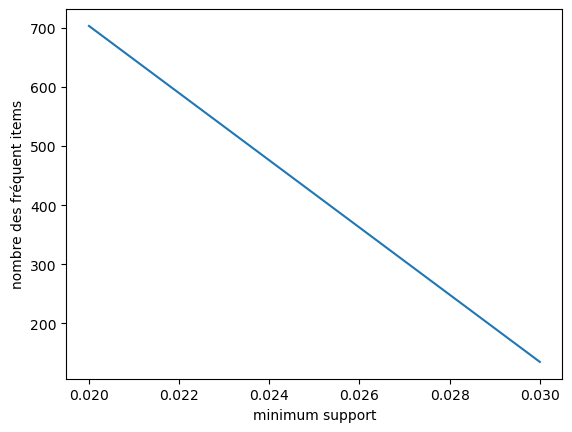

In [59]:
plt.plot(result_df.minsup, result_df.num_items)
plt.xlabel("minimum support")
plt.ylabel("nombre des fréquent items")
plt.show()

In [60]:
# initialise un petit seuil de confidence 10% afin de trouver maximum de règles
num_rules, rules, min_conf = [], [], 0.1
for f_items in freq_itemsets:
    ar = association_rules(f_items, metric='confidence', min_threshold=min_conf)
    rules.append(ar.sort_values(by='lift', ascending=False))
    num_rules.append(ar.shape[0])
result_df['num_rules'] = num_rules     
result_df['rules'] = rules
result_df[['minsup','num_items', 'num_rules']]

,minsup,num_items,num_rules
0,0.02,703,1600
1,0.03,135,112


In [63]:
freq_itemsets2 = apriori(df_billet, min_support=0.02, max_len=10, use_colnames=True)
print(freq_itemsets2.sort_values(by='support', ascending=True))

      support                                           itemsets
251  0.020017  (Back to the Future (1985), Jurassic Park (1993))
469  0.020017               (Mask, The (1994), True Lies (1994))
37   0.020017                     (Bourne Ultimatum, The (2007))
682  0.020017  (Terminator 2: Judgment Day (1991), Pulp Ficti...
296  0.020017  (Forrest Gump (1994), Clear and Present Danger...
..        ...                                                ...
162  0.070764                 (Silence of the Lambs, The (1991))
120  0.071046                               (Matrix, The (1999))
146  0.079786                              (Pulp Fiction (1994))
158  0.082323                 (Shawshank Redemption, The (1994))
71   0.085142                              (Forrest Gump (1994))

[703 rows x 2 columns]


In [64]:
regles2 = association_rules(freq_itemsets2,metric="confidence",min_threshold=0.11)

In [66]:
myRegles2 = regles2.loc[:, ['antecedents', 'consequents', 'lift', 'conviction']]